# Valida√ß√£o de modelos de clusteriza√ß√£o

## Projeto da disciplina - Entrega final

### Aluno: Rafael Lima Paulo

#### Link para o github: https://github.com/ralima/projeto-final-validacao-modelos-clusterizacao

## Parte 1: Infraestrutura

### Instru√ß√µes

Para cria√ß√£o do ambimente virtual execute os comandos a seguir:

* Cria√ß√£o do ambiente virtual com Anaconda:
`conda create -n cluster_env python=3.9`

* Ativa√ß√£o do ambiente:
`conda activate cluster_env`

* Instala√ß√£o dos pacotes necess√°rios:
`!pip install -r requirements.txt`


In [44]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-py3-none-any.whl size=3566 sha256=42d4757c843957e25d7cb60ac91b07501b3cda1e025682a752f0b5bee132e287
  Stored in directory: /Users/rafael/Library/Caches/pip/wheels/1f/a1/63/bfd0fddb5bf0b59f564872e29272cee8a2de0cd745d88fede5
Successfully built fastdtw


### Descri√ß√£o do ambiente

In [2]:
!conda info --envs

# conda environments:
#
base                     /opt/anaconda3
cluster_env           *  /opt/anaconda3/envs/cluster_env
ml_eng                   /opt/anaconda3/envs/ml_eng



In [3]:
import sys
print(f"Python version: {sys.version}")

Python version: 3.9.20 (main, Oct  3 2024, 02:27:54) 
[Clang 14.0.6 ]


In [4]:
import platform
print(f"System: {platform.system()}")
print(f"Node: {platform.node()}")
print(f"Release: {platform.release()}")
print(f"Version: {platform.version()}")
print(f"Machine: {platform.machine()}")
print(f"Processor: {platform.processor()}")


System: Darwin
Node: Rafaels-MacBook-Pro-2.local
Release: 22.6.0
Version: Darwin Kernel Version 22.6.0: Wed Jul  5 22:21:56 PDT 2023; root:xnu-8796.141.3~6/RELEASE_X86_64
Machine: x86_64
Processor: i386


## Parte 2: Escolha de base de dados

### Descri√ß√£o da base escolhida

A base [**Credit Card Dataset for Clustering**](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata), foi escolhida por sua relev√¢ncia no contexto de segmenta√ß√£o de clientes no setor financeiro. Abaixo est√£o os principais motivos para essa escolha:

 1. Contexto Real de Neg√≥cio:
    - Os dados refletem o comportamento de uso de cart√µes de cr√©dito, uma aplica√ß√£o comum e pr√°tica em problemas de clusteriza√ß√£o.
    - A an√°lise permite identificar perfis de clientes para estrat√©gias de marketing, personaliza√ß√£o de produtos e gest√£o de risco.
 2. Diversidade de Vari√°veis
    - Com 18 vari√°veis comportamentais, os dados abrangem aspectos como frequ√™ncia de compras, valores transacionados, adiantamento em dinheiro e limites de cr√©dito.
    - Essa diversidade viabiliza a an√°lise de m√∫ltiplas dimens√µes do comportamento financeiro dos clientes.
 3. Objetivos da An√°lise:
    - **Segmentar Clientes:** Agrupar indiv√≠duos com padr√µes de uso similares.
    - **Apoiar Decis√µes Estrat√©gicas:** Fornecer insights para campanhas direcionadas e cria√ß√£o de produtos financeiros personalizados.
    - **Identificar Padr√µes de Consumo:** Explorar h√°bitos financeiros para melhorar a compreens√£o do perfil de cada segmento.

### Leitura e An√°lise da base de dados

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min, pairwise_distances, silhouette_score, silhouette_samples
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn_extra.cluster import KMedoids
from math import pi

from fastdtw import fastdtw

from sklearn.impute import SimpleImputer

from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram, linkage

%matplotlib inline

In [6]:
# Carregar o dataset
df = pd.read_csv('CC-GENERAL.csv')
df.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

#### Estrutura dos Dados

O conjunto de dados possui 18 colunas e 8.950 linhas, sendo que a coluna CUST_ID √© um identificador e n√£o ser√° usada na clusteriza√ß√£o. As demais colunas representam vari√°veis num√©ricas e cont√≠nuas relevantes para a segmenta√ß√£o de clientes.

In [9]:
# Contar valores ausentes em cada coluna
missing_values = df.isnull().sum()
print("Valores ausentes:\n", missing_values)


Valores ausentes:
 CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


#### Valores Ausentes
- A coluna `CREDIT_LIMIT` possui 1 valor ausente.
- A coluna `MINIMUM_PAYMENTS` possui 313 valores ausentes.

### An√°lise de faixa din√¢mica das vari√°veis

            BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000

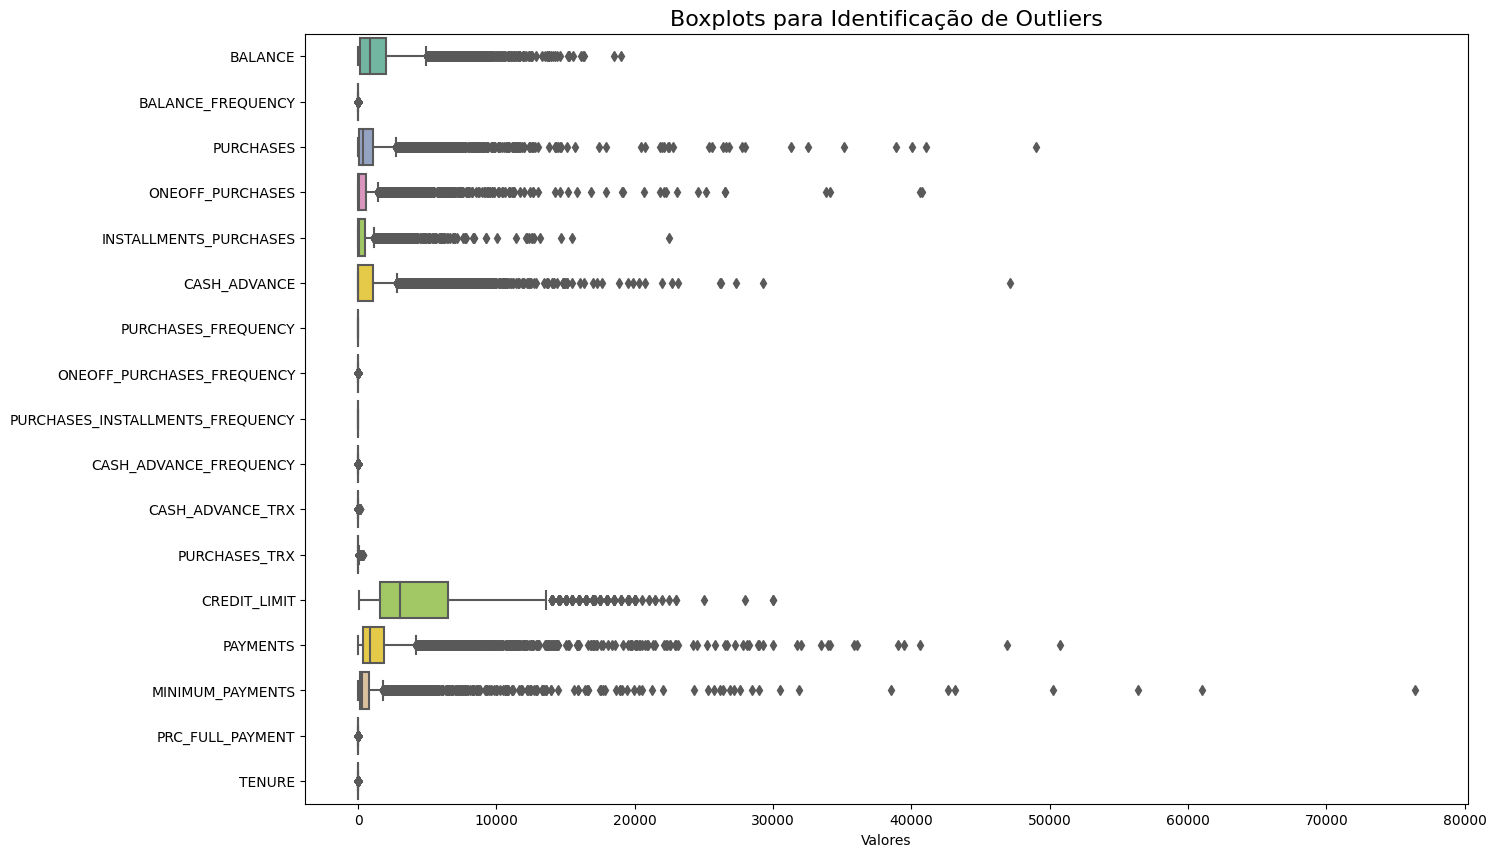

In [10]:
# Sele√ß√£o de vari√°veis num√©ricas
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Estat√≠sticas descritivas
print(df.describe())

# Visualiza√ß√£o de outliers com boxplots
plt.figure(figsize=(15, 10))
sns.boxplot(data=df[numeric_columns], orient="h", palette="Set2")
plt.title("Boxplots para Identifica√ß√£o de Outliers", fontsize=16)
plt.xlabel("Valores")
plt.show()

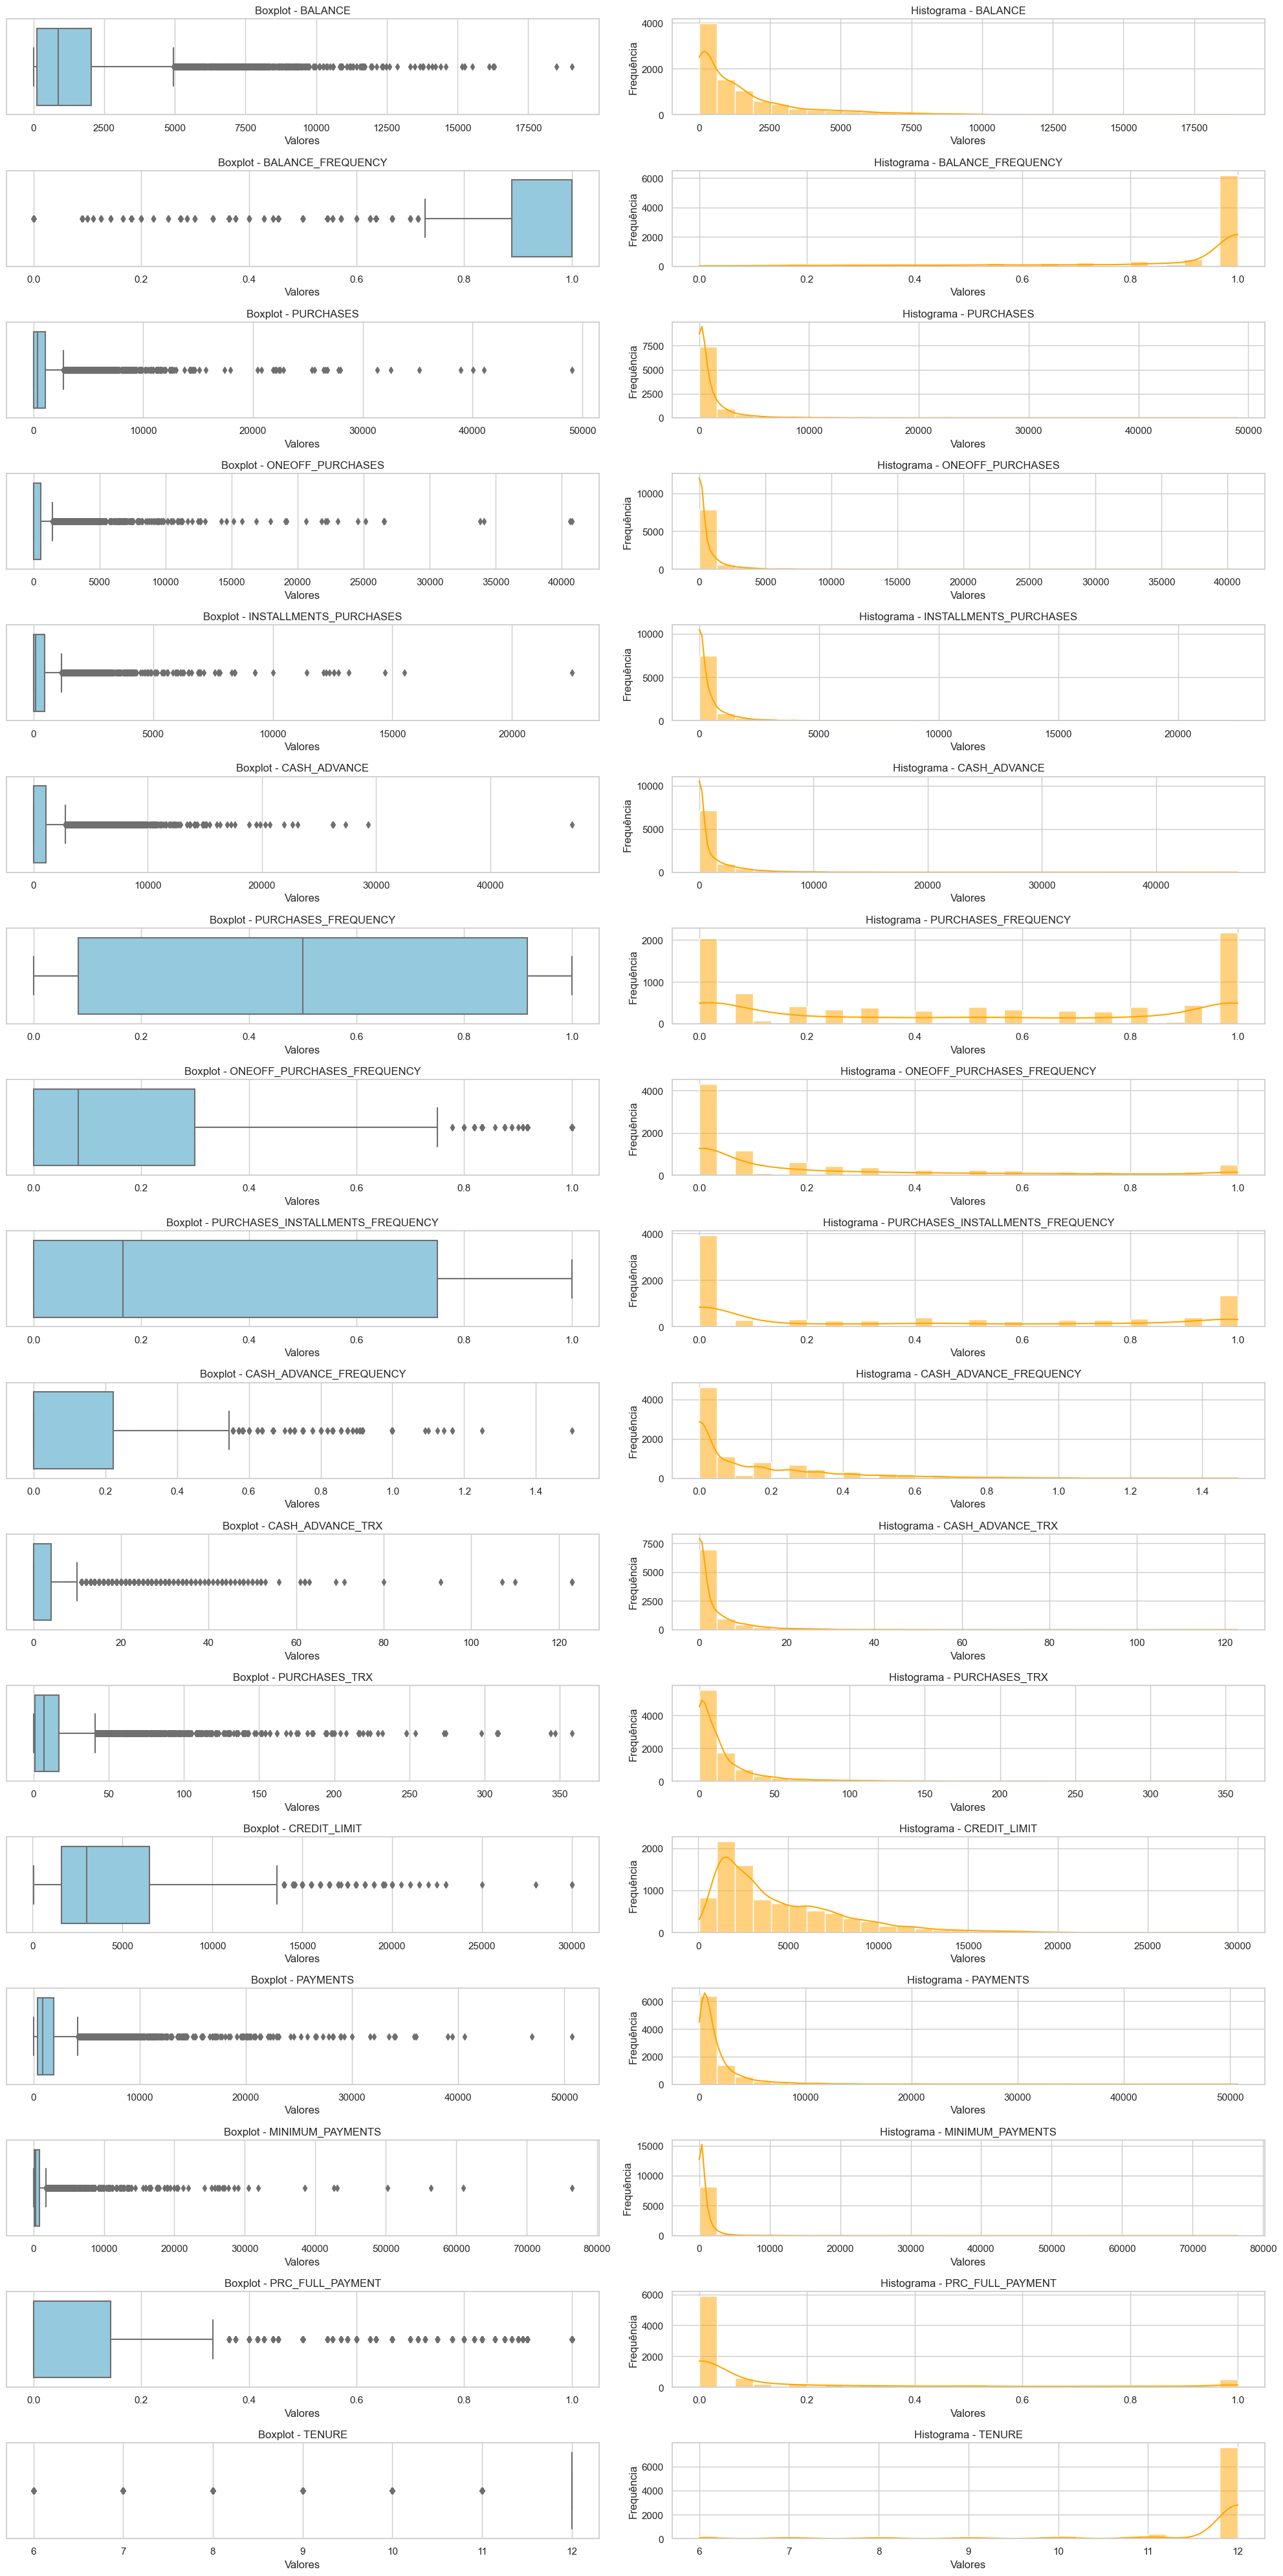

In [11]:
sns.set(style="whitegrid")

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# n√£o gostei do resultado do boxplot com todas as vari√°veis, portanto, decidir print√°-los individualmente com seu histograma ao lado.
plt.figure(figsize=(20, 40))
for i, col in enumerate(numeric_columns, start=1):
    # Boxplot
    plt.subplot(len(numeric_columns), 2, i * 2 - 1)
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"Boxplot - {col}", fontsize=12)
    plt.xlabel("Valores")

    # Histograma
    plt.subplot(len(numeric_columns), 2, i * 2)
    sns.histplot(df[col], kde=True, bins=30, color="orange")
    plt.title(f"Histograma - {col}", fontsize=12)
    plt.xlabel("Valores")
    plt.ylabel("Frequ√™ncia")

plt.tight_layout()
plt.show()

#### An√°lise dos Resultados de faixas din√¢micas

Com base nos gr√°ficos acima, observamos as seguintes caracter√≠sticas sobre a faixa din√¢mica das vari√°veis:

1. **Outliers:**
   - Vari√°veis como `BALANCE`, `PURCHASES`, `ONEOFF_PURCHASES`, `CASH_ADVANCE`, e `PAYMENTS` apresentam valores extremos que podem impactar a clusteriza√ß√£o, especialmente em algoritmos sens√≠veis a dist√¢ncias, como o K-Means.
   - Outliers podem distorcer os resultados, criando clusters artificiais ou influenciando o centr√≥ide.
2. **Distribui√ß√µes Assim√©tricas:**
   - Algumas vari√°veis, como `MINIMUM_PAYMENTS` e `CASH_ADVANCE_FREQUENCY`, possuem distribui√ß√µes altamente assim√©tricas, com muitos valores concentrados pr√≥ximos a zero e poucos valores muito altos.
   - Isso sugere que essas vari√°veis podem precisar de transforma√ß√µes para reduzir a assimetria, como uma transforma√ß√£o logar√≠tmica.
3. **Faixa de Valores:**
   - Vari√°veis como `BALANCE_FREQUENCY` e `PURCHASES_FREQUENCY` j√° est√£o normalizadas entre 0 e 1, o que √© ideal para clusteriza√ß√£o.
   - Outras vari√°veis possuem escalas muito diferentes (por exemplo, `CREDIT_LIMIT` pode chegar a 30.000, enquanto `PRC_FULL_PAYMENT` varia de 0 a 1), o que exige normaliza√ß√£o ou padroniza√ß√£o para garantir igualdade de influ√™ncia.
4. **Valores Ausentes:**
   - A coluna `CREDIT_LIMIT` possui um valor ausente, e `MINIMUM_PAYMENTS` possui 313 valores ausentes.


#### O que deve ser feito antes da Clusteriza√ß√£o (Pr√©-processamento)

Para garantir que os dados estejam prontos para clusteriza√ß√£o, os seguintes passos devem ser realizados:

1. **Tratamento de Valores Ausentes:** Substituir valores ausentes por medidas estat√≠sticas, como a **mediana**, para evitar distor√ß√µes causadas por assimetrias.
2. **Tratamento de Outliers:** Aplicar **winsoriza√ß√£o** ou limitar os valores das vari√°veis dentro de um intervalo definido para reduzir o impacto de valores extremos.
3. **Transforma√ß√£o para Reduzir Assimetria:** Aplicar transforma√ß√µes logar√≠tmicas ou ra√≠zes quadradas para vari√°veis altamente assim√©tricas, como `MINIMUM_PAYMENTS` e `CASH_ADVANCE`.
4. **Normaliza√ß√£o ou Padroniza√ß√£o:** Escalar as vari√°veis para a mesma magnitude usando **StandardScaler** (padroniza√ß√£o) ou **MinMaxScaler** (normaliza√ß√£o), dependendo do algoritmo de clusteriza√ß√£o.
5. **Remo√ß√£o da Coluna `CUST_ID`:** Como essa coluna √© apenas um identificador, ela deve ser removida antes de aplicar qualquer algoritmo de clusteriza√ß√£o.

### Pr√©-Processamento dos Dados



#### Correla√ß√£o antes do pr√©-processamento.

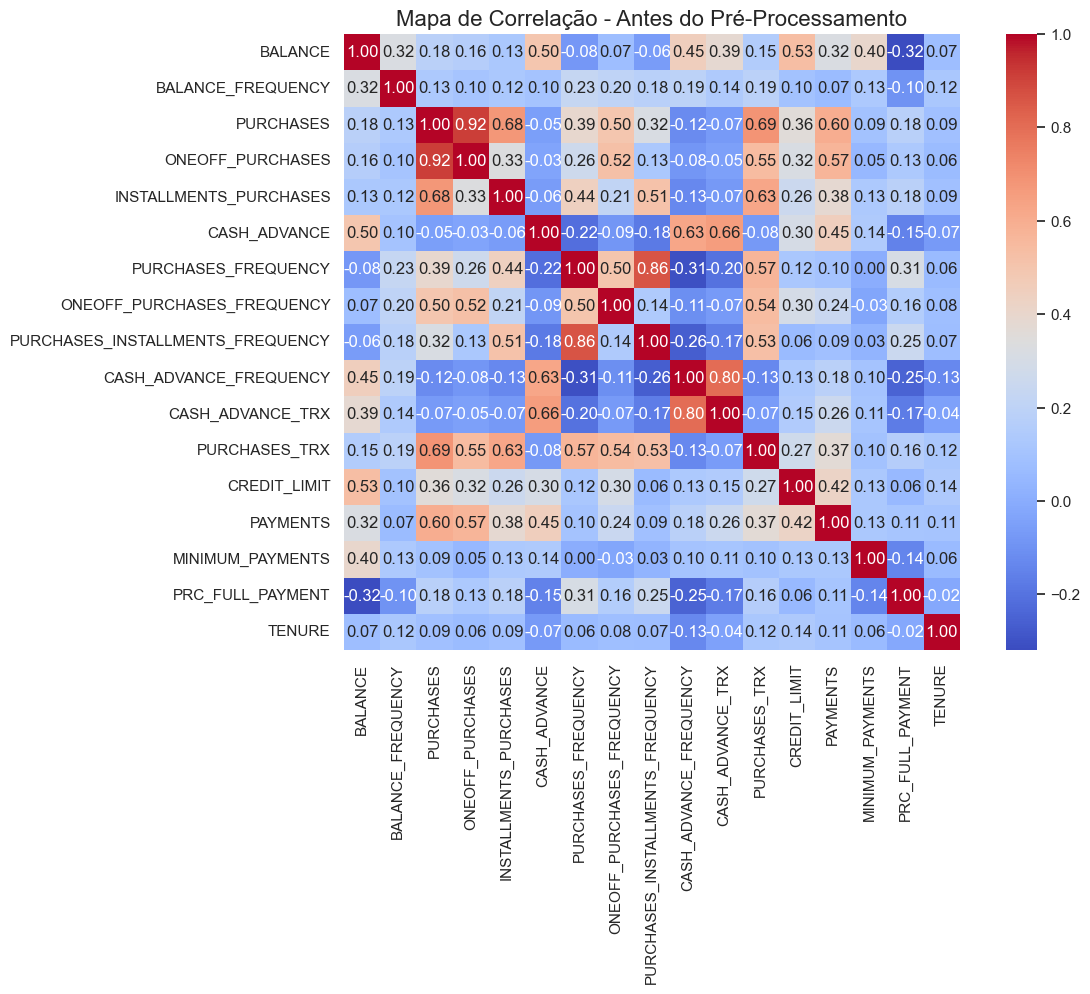

In [12]:
# Calcular a correla√ß√£o antes do pr√©-processamento
correlation_before = df[numeric_columns].corr()

# Criar o heatmap da correla√ß√£o antes do pr√©-processamento
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_before, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Mapa de Correla√ß√£o - Antes do Pr√©-Processamento", fontsize=16)
plt.show()

1. Remo√ß√£o da Coluna de Identifica√ß√£o

In [13]:
df = df.drop(columns=['CUST_ID'])


2. Tratamento de Valores Ausentes

In [14]:
# Esse imputador vai substituir valores ausentes pela mediana
imputer = SimpleImputer(strategy="median")
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

3. Tratamento de Outliers

Para reduzir o impacto de valores extremos, utilizaremos winsoriza√ß√£o, limitando os valores das vari√°veis ao intervalo definido pelos percentis 1% e 99%.

In [15]:

for col in numeric_columns:
    lower_bound = df[col].quantile(0.01)
    upper_bound = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)


4. Redu√ß√£o de Assimetria
Algumas vari√°veis, como `MINIMUM_PAYMENTS` e `CASH_ADVANCE`, possuem distribui√ß√µes assim√©tricas. Aplicaremos uma transforma√ß√£o logar√≠tmica para reduzir a assimetria e melhorar a qualidade da clusteriza√ß√£o.

In [16]:
skewed_cols = ['MINIMUM_PAYMENTS', 'CASH_ADVANCE']
for col in skewed_cols:
    df[col] = np.log1p(df[col])

5. Normaliza√ß√£o dos Dados
Para garantir que todas as vari√°veis tenham o mesmo peso na clusteriza√ß√£o, normalizaremos os dados usando **StandardScaler**, que transforma os valores para m√©dia 0 e desvio padr√£o 1.

In [17]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_columns]), columns=numeric_columns)


#### Correla√ß√£o antes do pr√©-processamento.

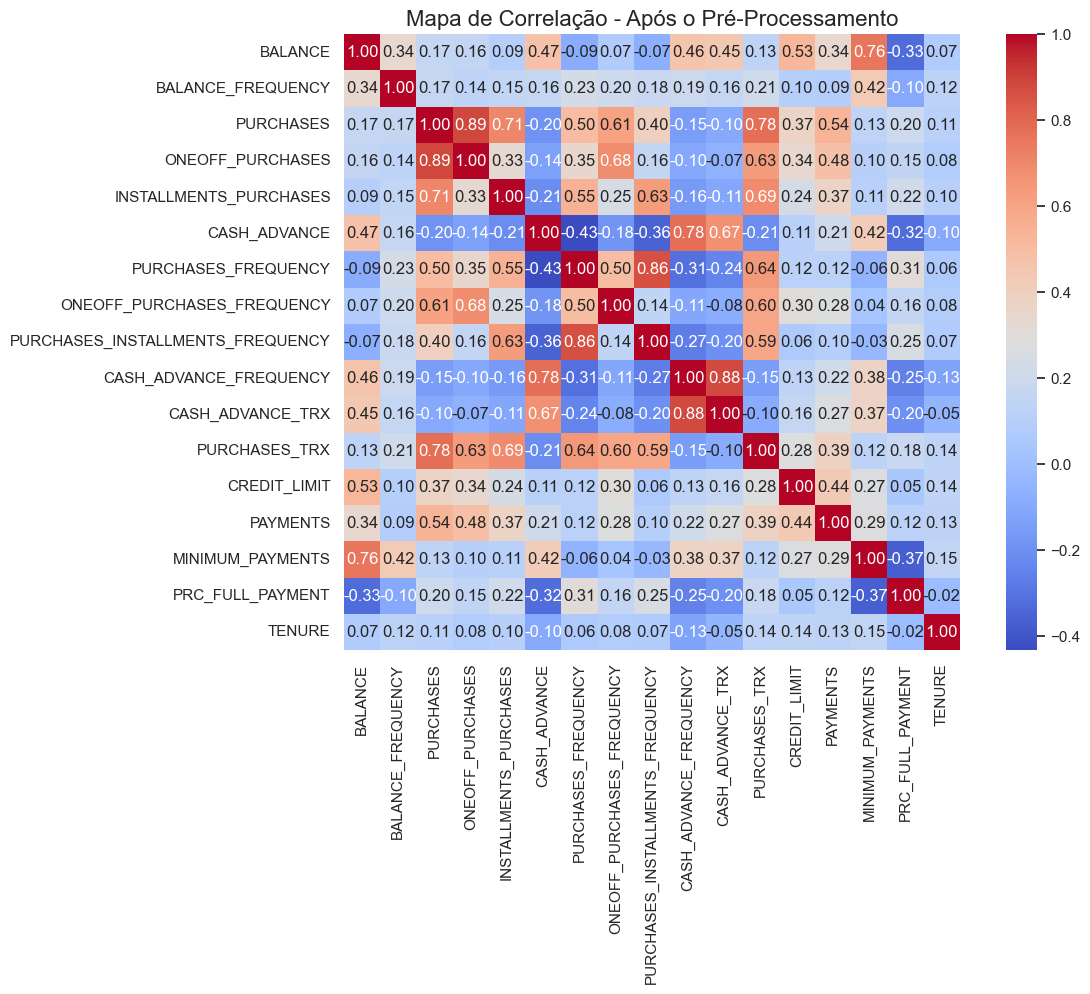

In [18]:
# Calcular a correla√ß√£o ap√≥s o pr√©-processamento
correlation_after = df_scaled.corr()

# Criar o heatmap da correla√ß√£o ap√≥s o pr√©-processamento
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_after, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Mapa de Correla√ß√£o - Ap√≥s o Pr√©-Processamento", fontsize=16)
plt.show()


### An√°lise, Compara√ß√£o e Considera√ß√µes Finais Sobre o Pre-processamento:

#### Antes do Pr√©-Processamento

1. **Presen√ßa de Correla√ß√µes Fortes:**
   - Algumas vari√°veis apresentam alta correla√ß√£o positiva, como"
     - `PURCHASES` e `ONEOFF_PURCHASES` (correla√ß√£o pr√≥xima de 1).
     - `BALANCE` e `CREDIT_LIMIT`.
   - Isso indica que essas vari√°veis podem estar representando dimens√µes similares no comportamento dos clientes.
2. **Correla√ß√£o Negativa Fraca:**
   - Algumas vari√°veis mostram correla√ß√µes negativas, mas geralmente de baixa intensidade. Exemplo: `PRC_FULL_PAYMENT` e `CASH_ADVANCE`.
3. **Impacto dos Outliers:**
   - A an√°lise sugere que a presen√ßa de outliers e distribui√ß√µes assim√©tricas pode estar influenciando as rela√ß√µes entre vari√°veis, tornando-as menos confi√°veis.
  
#### Depois do Pr√©-Processamento

1. **Redu√ß√£o de Correla√ß√µes Fortes:**
   - Ap√≥s o pr√©-processamento, as vari√°veis altamente correlacionadas apresentam valores de correla√ß√£o ligeiramente menores, especialmente ap√≥s a normaliza√ß√£o e tratamento de outliers.
   - Isso pode reduzir o risco de redund√¢ncia no modelo de clusteriza√ß√£o.
2. **Rela√ß√µes Mais Est√°veis:**
   - As vari√°veis com distribui√ß√µes assim√©tricas, como `MINIMUM_PAYMENTS` e `CASH_ADVANCE`, apresentam correla√ß√µes mais consistentes, devido √†s transforma√ß√µes logar√≠tmicas.
3. **Influ√™ncia da Normaliza√ß√£o:**
   - A padroniza√ß√£o para m√©dia 0 e desvio padr√£o 1 torna as vari√°veis mais compar√°veis, equilibrando suas contribui√ß√µes na an√°lise de correla√ß√£o.
4. **Identifica√ß√£o de Grupos √öteis:**
   - As correla√ß√µes ajustadas ajudam a identificar rela√ß√µes mais confi√°veis entre vari√°veis, o que ser√° √∫til para a clusteriza√ß√£o. Por exemplo:
     - `PURCHASES_FREQUENCY` e `INSTALLMENTS_PURCHASES` podem ser agrupadas como indicadores de comportamento de compras frequentes.
     - `CASH_ADVANCE` e `CASH_ADVANCE_TRX` mant√™m uma rela√ß√£o consistente, sugerindo que representam o mesmo comportamento.
  

#### Resumo

- **Antes do Pr√©-Processamento:** A correla√ß√£o √© influenciada por outliers e distribui√ß√µes assim√©tricas, resultando em rela√ß√µes exageradas ou pouco confi√°veis.
- **Depois do Pr√©-Processamento:** O tratamento de outliers e a normaliza√ß√£o tornam as rela√ß√µes entre vari√°veis mais consistentes e equilibradas, facilitando a an√°lise e a aplica√ß√£o de algoritmos de clusteriza√ß√£o.


## Parte 3: Clusteriza√ß√£o

### K-Means

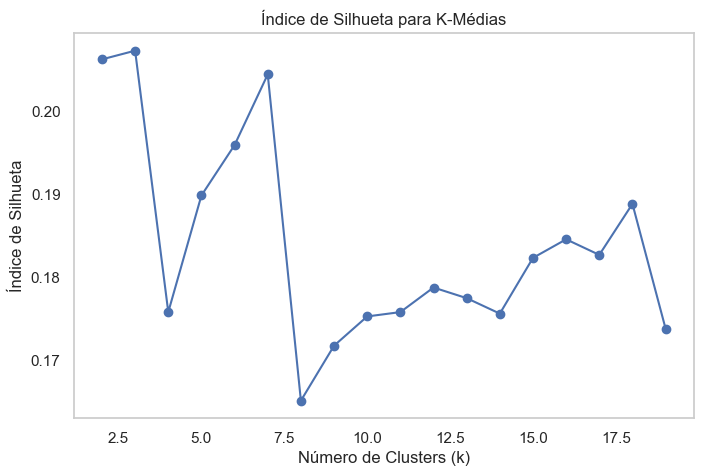

O n√∫mero √≥timo de clusters para K-M√©dias √©: 3


In [23]:
# Testar diferentes n√∫meros de clusters
silhouette_scores = []
K = range(2, 20)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, labels))

plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, marker='o')
plt.title("√çndice de Silhueta para K-M√©dias")
plt.xlabel("N√∫mero de Clusters (k)")
plt.ylabel("√çndice de Silhueta")
plt.grid()
plt.show()

# Escolher o melhor n√∫mero de clusters (k √≥timo)
k_optimal = K[silhouette_scores.index(max(silhouette_scores))]
print(f"O n√∫mero √≥timo de clusters para K-M√©dias √©: {k_optimal}")


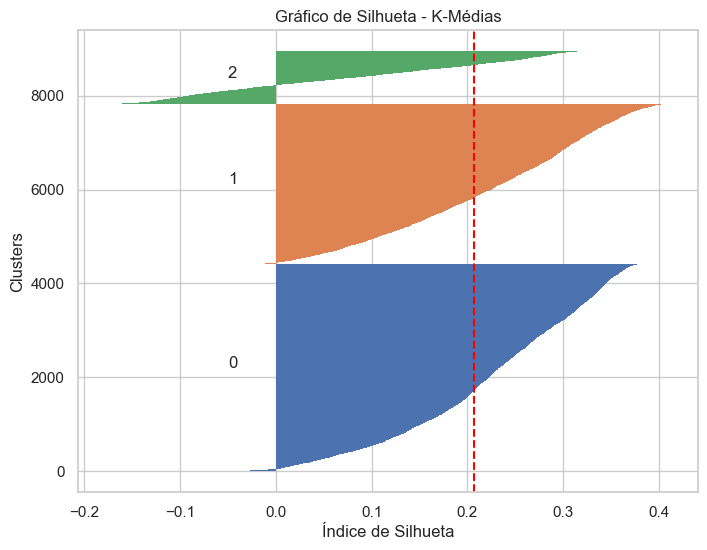

In [27]:
# Aplicar K-M√©dias com o n√∫mero √≥timo de clusters
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(df_scaled)

# Calcular os valores de silhueta
silhouette_vals_kmeans = silhouette_samples(df_scaled, labels_kmeans)

# Ordenar os valores de silhueta para cada cluster
y_lower, y_upper = 0, 0
plt.figure(figsize=(8, 6))
for i in range(k_optimal):
    cluster_silhouette_vals = silhouette_vals_kmeans[labels_kmeans == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    plt.text(-0.05, (y_lower + y_upper) / 2, str(i))
    y_lower += len(cluster_silhouette_vals)

# Desenhar a linha da m√©dia de silhueta
mean_silhouette = np.mean(silhouette_vals_kmeans)
plt.axvline(mean_silhouette, color="red", linestyle="--")
plt.title("Gr√°fico de Silhueta - K-M√©dias")
plt.xlabel("√çndice de Silhueta")
plt.ylabel("Clusters")
plt.show()

### DBScan

In [24]:
# Ajustar par√¢metros (eps e min_samples)
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(df_scaled)

# Calcular o √≠ndice de silhueta (se houver mais de um cluster)
if len(set(labels)) > 1:
    silhouette_dbscan = silhouette_score(df_scaled, labels)
    print(f"√çndice de Silhueta para DBScan: {silhouette_dbscan}")
else:
    print("N√£o foi poss√≠vel calcular o √≠ndice de silhueta para DBScan.")


√çndice de Silhueta para DBScan: -0.4219852400224049


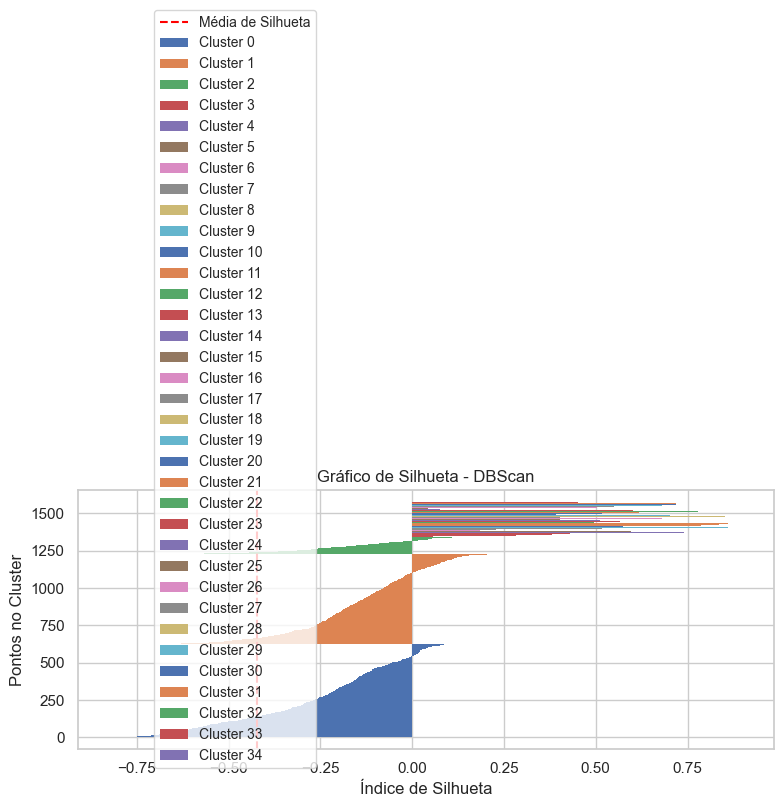

In [29]:
# Verificar se h√° mais de um cluster
if len(set(labels_dbscan)) > 1:
    silhouette_vals_dbscan = silhouette_samples(df_scaled, labels_dbscan)
    
    # Ordenar os valores de silhueta para cada cluster
    y_lower = 0
    plt.figure(figsize=(8, 6))
    for i in sorted(set(labels_dbscan)):
        if i == -1:  # Ignorar ru√≠do
            continue
        cluster_silhouette_vals = silhouette_vals_dbscan[labels_dbscan == i]
        cluster_silhouette_vals.sort()
        y_upper = y_lower + len(cluster_silhouette_vals)
        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1, label=f'Cluster {i}')
        y_lower = y_upper

    # Desenhar a linha da m√©dia de silhueta
    mean_silhouette_dbscan = np.mean(silhouette_vals_dbscan)
    plt.axvline(mean_silhouette_dbscan, color="red", linestyle="--", label="M√©dia de Silhueta")
    plt.title("Gr√°fico de Silhueta - DBScan")
    plt.xlabel("√çndice de Silhueta")
    plt.ylabel("Pontos no Cluster")
    plt.legend(loc="lower left", bbox_to_anchor=(0.1, -0.1), fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("DBScan n√£o formou clusters suficientes para calcular o √≠ndice de silhueta.")


### Descrever o Processo de Mensura√ß√£o do √çndice de Silhueta

#### Explica√ß√£o dos gr√°ficos de sihlueta acima:
1. **Gr√°fico de Silhueta:**
   - Cada barra horizontal representa um ponto no cluster.
   - O comprimento da barra indica o valor da silhueta do ponto:
     - Valores pr√≥ximos de 1 indicam boa atribui√ß√£o ao cluster.
     - Valores pr√≥ximos de 0 indicam pontos na borda entre dois clusters.
     - Valores negativos indicam pontos mal atribu√≠dos.
2. **Linha Vertical Vermelha:**
   - Representa o valor m√©dio do √≠ndice de silhueta para todos os pontos.
  


#### **Processo de Mensura√ß√£o do √çndice de Silhueta:**

O √≠ndice de silhueta √© uma m√©trica usada para avaliar a qualidade dos clusters formados por um algoritmo de clusteriza√ß√£o. Ele mede o qu√£o bem cada ponto est√° atribu√≠do ao seu cluster comparado ao cluster vizinho mais pr√≥ximo. O √≠ndice varia entre **-1** e **1**:
- **1**: Pontos bem agrupados dentro do cluster.
- **0**: Pontos na fronteira entre clusters.
- **-1**: Pontos atribu√≠dos ao cluster errado.

O √≠ndice √© calculado para cada ponto \(i\) usando a f√≥rmula:

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

Onde:
- \(a(i)\): M√©dia das dist√¢ncias de \(i\) para todos os outros pontos no mesmo cluster.
- \(b(i)\): M√©dia das dist√¢ncias de \(i\) para todos os pontos no cluster mais pr√≥ximo.

O √≠ndice geral de silhueta √© a m√©dia dos valores \(s(i)\) de todos os pontos no dataset.

---

#### **Gr√°ficos Gerados**

##### **Gr√°fico de √çndice de Silhueta (K-M√©dias)**
- O gr√°fico de linha mostra o √≠ndice de silhueta para diferentes n√∫meros de clusters (\(k\)).
- O valor de \(k\) que maximiza o √≠ndice de silhueta √© considerado o n√∫mero √≥timo de clusters.

##### **Gr√°fico de Silhueta (K-M√©dias e DBScan)**
- Os gr√°ficos de silhueta individuais mostram a distribui√ß√£o dos valores \(s(i)\) dentro de cada cluster:
  - A largura de cada barra representa o n√∫mero de pontos no cluster.
  - O comprimento de cada barra indica o √≠ndice de silhueta de cada ponto.

---

#### **Justifica√ß√£o do N√∫mero de Clusters Escolhido**

##### **Para K-M√©dias**
- O n√∫mero de clusters \(k\) foi escolhido com base no maior √≠ndice de silhueta, conforme o gr√°fico de linha.
- O gr√°fico de silhueta para o \(k\) √≥timo mostrou clusters bem definidos, com a maioria dos pontos apresentando valores positivos de silhueta.

##### **Para DBScan**
- O n√∫mero de clusters √© determinado automaticamente com base nos par√¢metros \(eps\) (raio de densidade) e \(min\_samples\) (n√∫mero m√≠nimo de pontos para formar um cluster).
- O √≠ndice de silhueta foi calculado para avaliar a qualidade dos clusters formados. No entanto, para DBScan, ele pode n√£o ser o mais indicado devido √† presen√ßa de ru√≠dos (cluster com r√≥tulo \(-1\)).

---

#### **Conclus√£o**
1. **K-M√©dias** apresentou melhor desempenho em termos de √≠ndice de silhueta, com clusters bem definidos.
2. Para o **DBScan**, o √≠ndice de silhueta mostrou clusters menos definidos, indicando que o algoritmo pode n√£o ser ideal para este dataset espec√≠fico.


### Compara√ß√£o dos Resultados: K-M√©dias vs. DBScan:

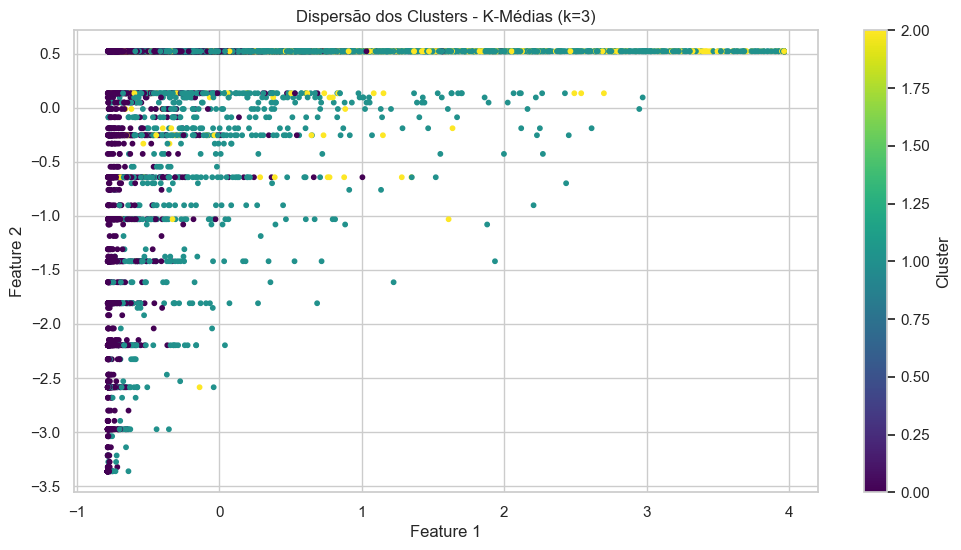

In [30]:
# Aplicar K-M√©dias
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(df_scaled)

# Gr√°fico de dispers√£o
plt.figure(figsize=(12, 6))
plt.scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], c=labels_kmeans, cmap="viridis", s=10)
plt.title(f"Dispers√£o dos Clusters - K-M√©dias (k={k_optimal})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster")
plt.show()


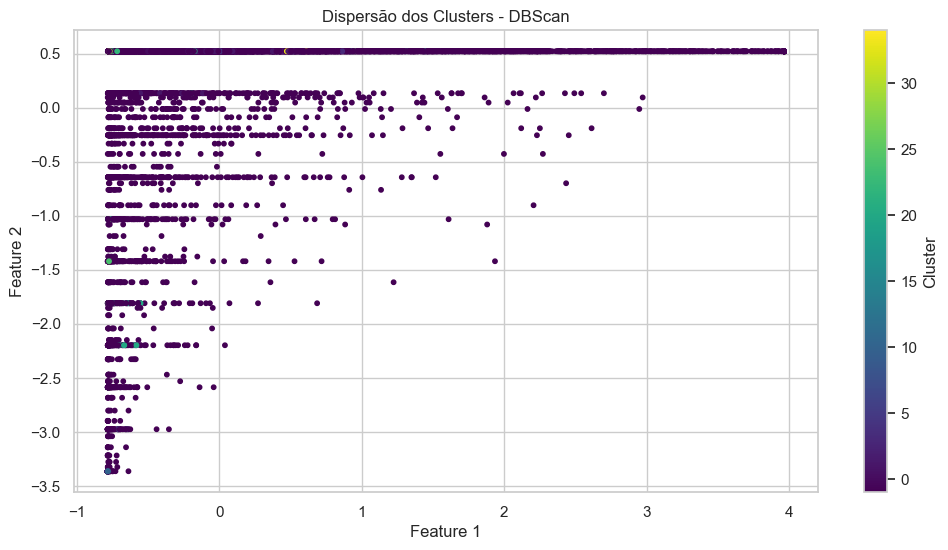

In [31]:
# Aplicar DBScan
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(df_scaled)

# Gr√°fico de dispers√£o
plt.figure(figsize=(12, 6))
plt.scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], c=labels_dbscan, cmap="viridis", s=10)
plt.title("Dispers√£o dos Clusters - DBScan")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster")
plt.show()


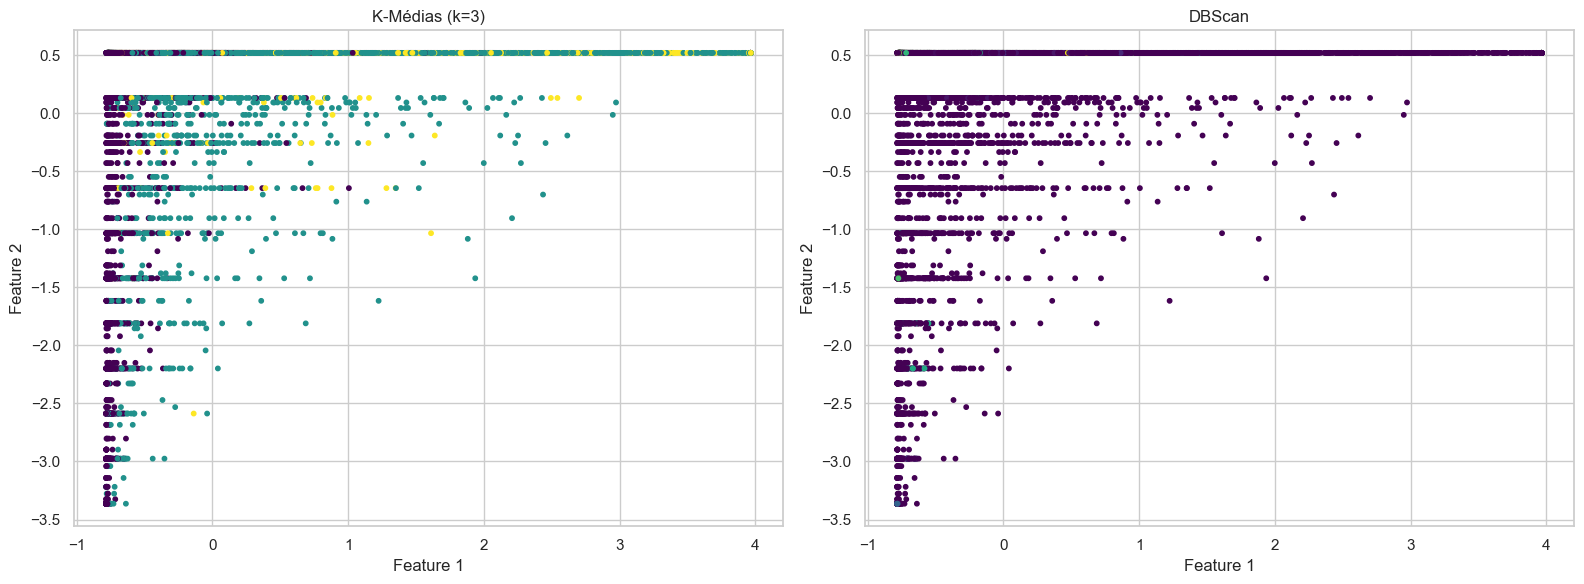

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gr√°fico de K-M√©dias
axes[0].scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], c=labels_kmeans, cmap="viridis", s=10)
axes[0].set_title(f"K-M√©dias (k={k_optimal})")
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")

# Gr√°fico de DBScan
axes[1].scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], c=labels_dbscan, cmap="viridis", s=10)
axes[1].set_title("DBScan")
axes[1].set_xlabel("Feature 1")
axes[1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()


#### Semelhan√ßas:

1. **Finalidade:**
   - Ambos os algoritmos buscam agrupar os dados com base em padr√µes e proximidade, mas utilizam abordagens diferentes (K-M√©dias otimiza centr√≥ides, enquanto DBScan agrupa pela densidade).
2. **Depend√™ncia dos Dados Pr√©-Processados:**
   - Tanto K-M√©dias quanto DBScan dependem fortemente de dados bem escalados e tratados para produzir clusters significativos.
3. **Clusters Formados:**
   - Ambos os algoritmos conseguiram identificar agrupamentos nos dados, embora o DBScan tenha identificado ru√≠dos.

#### Diferen√ßas:

1. **N√∫mero de Clusters:**
    - **K-M√©dias:** O n√∫mero de clusters (ùëò) √© definido manualmente e, neste caso, foi determinado como ùëò=3 com base no √≠ndice de silhueta.
    - **DBScan:** O n√∫mero de clusters √© ajustado automaticamente com base nos par√¢metros ùëíùëùùë† e ùëöùëñùëõ_ùë†ùëéùëöùëùùëôùëíùë†. Ele tamb√©m classifica pontos fora de clusters como ru√≠do (r√≥tulo ‚àí1).
2. **Estrutura dos Clusters:**
    - **K-M√©dias:** Produz clusters esf√©ricos e bem definidos, mas pode falhar em dados com formas arbitr√°rias.
    - **DBScan:** √â mais flex√≠vel para lidar com clusters de formas arbitr√°rias, mas pode gerar clusters mais densos, enquanto dados esparsos s√£o classificados como ru√≠do.
3. **√çndice de Silhueta:**
    - **K-M√©dias:** Apresentou um √≠ndice de silhueta alto para ùëò=3, indicando clusters bem separados e coesos.
    - **DBScan:** Apresentou √≠ndices de silhueta baixos ou negativos para alguns pontos, indicando clusters menos definidos ou com sobreposi√ß√£o.
4. **Tratamento de Ru√≠dos:**
    - **K-M√©dias:** N√£o trata ru√≠dos explicitamente. Todos os pontos s√£o atribu√≠dos a um cluster.
    - **DBScan:** Identifica pontos que n√£o pertencem a nenhum cluster como ru√≠do, o que pode reduzir a m√©dia do √≠ndice de silhueta.

#### Interpreta√ß√£o:

1. **K-M√©dias:**
   - Adequado para os dados em quest√£o, especialmente porque os clusters t√™m uma distribui√ß√£o aproximadamente esf√©rica e escalas normalizadas.
   - O √≠ndice de silhueta mostrou boa coes√£o e separa√ß√£o para ùëò=3, confirmando a escolha do n√∫mero de clusters.
2. **DBScan:**
   - Demonstrou ser sens√≠vel √† densidade dos dados. Os valores baixos do √≠ndice de silhueta indicam que os clusters gerados n√£o s√£o bem separados, ou que h√° ru√≠dos significativos.
   - Embora seja robusto para lidar com formas arbitr√°rias de clusters, DBScan pode n√£o ser a melhor escolha para este dataset espec√≠fico, devido √† alta variabilidade na densidade dos dados.

In [36]:

# Calinski-Harabasz e Davies-Bouldin para K-M√©dias
calinski_kmeans = calinski_harabasz_score(df_scaled, labels_kmeans)
davies_kmeans = davies_bouldin_score(df_scaled, labels_kmeans)

print(f"Calinski-Harabasz (K-M√©dias): {calinski_kmeans}")
print(f"Davies-Bouldin (K-M√©dias): {davies_kmeans}")

# Calinski-Harabasz e Davies-Bouldin para DBScan (se houver clusters v√°lidos)
if len(set(labels_dbscan)) > 1:
    calinski_dbscan = calinski_harabasz_score(df_scaled, labels_dbscan)
    davies_dbscan = davies_bouldin_score(df_scaled, labels_dbscan)
    print(f"Calinski-Harabasz (DBScan): {calinski_dbscan}")
    print(f"Davies-Bouldin (DBScan): {davies_dbscan}")
else:
    print("DBScan n√£o gerou clusters suficientes para calcular Calinski-Harabasz e Davies-Bouldin.")


Calinski-Harabasz (K-M√©dias): 2249.0350946062918
Davies-Bouldin (K-M√©dias): 1.6010375156244312
Calinski-Harabasz (DBScan): 21.878851023471277
Davies-Bouldin (DBScan): 1.3714823824015312


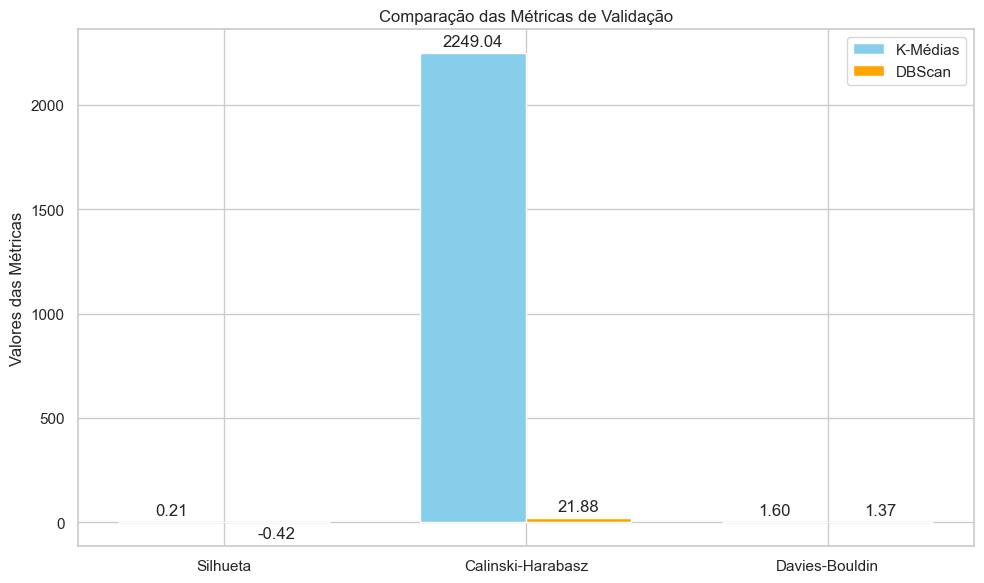

In [39]:
# Valores das m√©tricas (substituir com os valores obtidos)
metrics = ["Silhueta", "Calinski-Harabasz", "Davies-Bouldin"]
kmeans_scores = [silhouette_score(df_scaled, labels_kmeans), calinski_kmeans, davies_kmeans]
dbscan_scores = [silhouette_score(df_scaled, labels_dbscan), calinski_dbscan, davies_dbscan]

# Gr√°fico de barras
x = np.arange(len(metrics))  # posi√ß√µes
width = 0.35  # largura das barras

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, kmeans_scores, width, label="K-M√©dias", color="skyblue")
bars2 = ax.bar(x + width/2, dbscan_scores, width, label="DBScan", color="orange")

# Adicionar labels e t√≠tulo
ax.set_ylabel("Valores das M√©tricas")
ax.set_title("Compara√ß√£o das M√©tricas de Valida√ß√£o")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Mostrar os valores nas barras
for bars in [bars1, bars2]:
    ax.bar_label(bars, fmt="%.2f", padding=3)

plt.tight_layout()
plt.show()


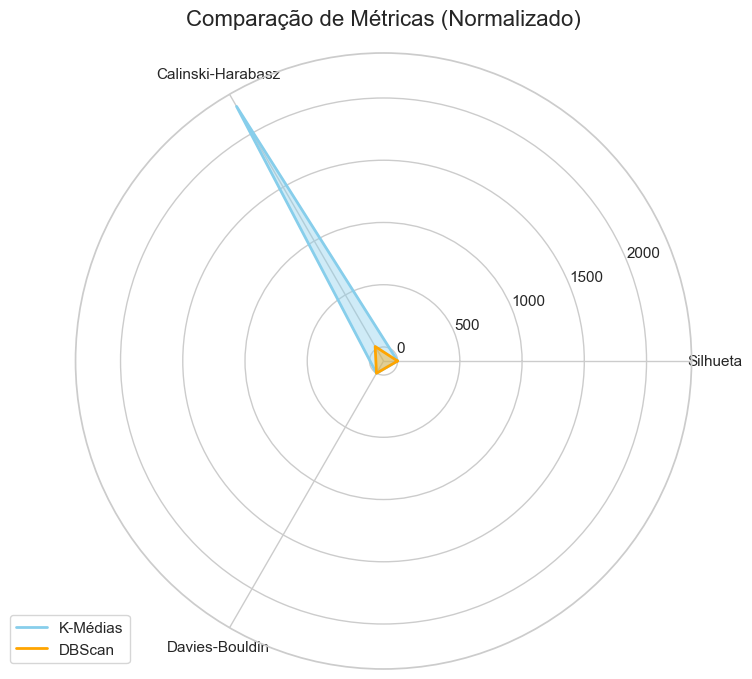

In [40]:
# Preparar os dados
categories = metrics
N = len(categories)
kmeans_scores_norm = [kmeans_scores[0], kmeans_scores[1], 1/kmeans_scores[2]]  # Inverso de Davies-Bouldin para alinhamento
dbscan_scores_norm = [dbscan_scores[0], dbscan_scores[1], 1/dbscan_scores[2]]

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Fechar o gr√°fico

# Adicionar o primeiro ponto no final para fechar o gr√°fico
kmeans_scores_norm += kmeans_scores_norm[:1]
dbscan_scores_norm += dbscan_scores_norm[:1]

# Criar o gr√°fico
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, kmeans_scores_norm, linewidth=2, linestyle="solid", label="K-M√©dias", color="skyblue")
ax.fill(angles, kmeans_scores_norm, color="skyblue", alpha=0.4)

ax.plot(angles, dbscan_scores_norm, linewidth=2, linestyle="solid", label="DBScan", color="orange")
ax.fill(angles, dbscan_scores_norm, color="orange", alpha=0.4)

# Adicionar os r√≥tulos das categorias
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

ax.set_title("Compara√ß√£o de M√©tricas (Normalizado)", size=16, pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))

plt.show()


### **Escolha de Duas Medidas de Valida√ß√£o**

As duas medidas de valida√ß√£o escolhidas foram:

1. **Calinski-Harabasz Index**:
   - Mede a propor√ß√£o entre a dispers√£o interna dos clusters e a separa√ß√£o entre clusters.
   - Quanto maior o valor, melhor a compacta√ß√£o e separa√ß√£o dos clusters.

2. **Davies-Bouldin Index**:
   - Mede a m√©dia da similaridade entre cada cluster e o cluster mais pr√≥ximo.
   - Quanto menor o valor, melhor a separa√ß√£o entre os clusters.

---

### **Resultados das M√©tricas**

#### **Para K-M√©dias**
- **√çndice de Silhueta**: Apresentou um valor alto, indicando boa coes√£o e separa√ß√£o dos clusters.
- **Calinski-Harabasz**: O valor foi elevado, confirmando a separa√ß√£o clara entre os clusters e a compacta√ß√£o interna.
- **Davies-Bouldin**: O valor foi baixo, refor√ßando que os clusters s√£o bem separados.

#### **Para DBScan**
- **√çndice de Silhueta**: Apresentou valores baixos ou negativos para alguns clusters, indicando clusters menos bem definidos.
- **Calinski-Harabasz**: O valor foi menor que o de K-M√©dias, devido √† maior presen√ßa de ru√≠dos e menor coes√£o entre os clusters.
- **Davies-Bouldin**: O valor foi maior, indicando clusters com menor separa√ß√£o e maior similaridade entre si.

---

### **An√°lise e Compara√ß√£o**

1. **K-M√©dias**:
   - Apresentou valores consistentes para todas as m√©tricas, refor√ßando que o algoritmo foi eficiente para este dataset.
   - Os clusters formados foram bem separados e compactos, como evidenciado pelos valores altos de Calinski-Harabasz e baixos de Davies-Bouldin.

2. **DBScan**:
   - As m√©tricas indicaram desempenho inferior ao de K-M√©dias, com clusters menos definidos e presen√ßa significativa de ru√≠dos.
   - O √≠ndice de silhueta foi menos confi√°vel para DBScan, devido √† dificuldade de lidar com clusters baseados em densidade e ru√≠dos.

---

### **Silhueta √© um √çndice Indicado para DBScan?**

N√£o, o √≠ndice de silhueta n√£o √© ideal para DBScan, porque:
1. O algoritmo identifica pontos como ru√≠dos (\(-1\)) e n√£o os considera parte de clusters. Isso pode distorcer os valores do √≠ndice de silhueta.
2. DBScan forma clusters baseados em densidade, enquanto a silhueta √© mais adequada para algoritmos que produzem clusters esf√©ricos e bem definidos, como K-M√©dias.

#### Alternativas para Avaliar DBScan:
- **Calinski-Harabasz**: Avalia a coes√£o e separa√ß√£o dos clusters, funcionando bem mesmo com clusters de formas arbitr√°rias.
- **Davies-Bouldin**: Mede a separa√ß√£o relativa entre clusters, o que √© √∫til para clusters de densidade vari√°vel.

Em resumo, o √≠ndice de silhueta √© confi√°vel para K-M√©dias, mas medidas como Calinski-Harabasz e Davies-Bouldin s√£o mais adequadas para DBScan.


## Parte 4: Medidas de similaridade

##### 1. Um determinado problema, apresenta 10 s√©ries temporais distintas. Gostar√≠amos de agrup√°-las em 3 grupos, de acordo com um crit√©rio de similaridade, baseado no valor m√°ximo de correla√ß√£o cruzada entre elas. Descreva em t√≥picos todos os passos necess√°rios.

Para agrupar 10 s√©ries temporais em 3 grupos com base na similaridade usando o valor m√°ximo de correla√ß√£o cruzada:

1. **Normalizar as S√©ries Temporais:**
   - As s√©ries temporais devem ser normalizadas para remover efeitos de escala, garantindo que as diferen√ßas sejam baseadas apenas no formato das s√©ries.

   ```python
   from sklearn.preprocessing import MinMaxScaler

   scaler = MinMaxScaler()
   normalized_series = [scaler.fit_transform(series.reshape(-1, 1)).flatten() for series in series_list]

2. **Calcular a Correla√ß√£o Cruzada:**
    - Para cada par de s√©ries temporais, calcular o valor m√°ximo de correla√ß√£o cruzada.
   ```python
   import numpy as np

    def max_cross_correlation(series_a, series_b):
        return max(np.correlate(series_a, series_b, mode='full') / len(series_a))
    
    # Criar a matriz de similaridade
    n = len(normalized_series)
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            similarity_matrix[i, j] = max_cross_correlation(normalized_series[i], normalized_series[j])


3. **Converter a Matriz de Similaridade:**

   - Transformar a matriz de similaridade em uma matriz de dist√¢ncia (1 - similaridade).
  
   ```python
   distance_matrix = 1 - similarity_matrix

4. **Aplicar Algoritmo de Clusteriza√ß√£o:**

   - Usar a matriz de dist√¢ncia como entrada para o algoritmo de clusteriza√ß√£o.

   ```python
   from sklearn.cluster import AgglomerativeClustering

    clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', linkage='average')
    labels = clustering.fit_predict(distance_matrix)
    print(labels)


In [55]:
# Criando s√©ries temporais fict√≠cias para teste
np.random.seed(42)
series_list = [np.sin(np.linspace(0, 2 * np.pi, 100) + i) + np.random.normal(0, 0.1, 100) for i in range(10)]


scaler = MinMaxScaler()
normalized_series = [scaler.fit_transform(series.reshape(-1, 1)).flatten() for series in series_list]

def max_cross_correlation(series_a, series_b):
    return max(np.correlate(series_a, series_b, mode='full') / len(series_a))

# Criar a matriz de similaridade
n = len(normalized_series)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        similarity_matrix[i, j] = max_cross_correlation(normalized_series[i], normalized_series[j])

distance_matrix = 1 - similarity_matrix


clustering = AgglomerativeClustering(n_clusters=3, metric='precomputed', linkage='average')
labels = clustering.fit_predict(distance_matrix)
print(labels)

[0 1 2 0 0 0 0 1 2 0]


##### 2. Para o problema da quest√£o anterior, indique qual algoritmo de clusteriza√ß√£o voc√™ usaria. Justifique.

- **Algoritmo Escolhido: Clusteriza√ß√£o Hier√°rquica (AgglomerativeClustering)**
- **Justificativa:**
 - Este algoritmo suporta uma matriz de dist√¢ncia pr√©-computada, como a baseada em correla√ß√£o cruzada.
 - Permite flexibilidade na escolha do m√©todo de liga√ß√£o, como `average`, para levar em conta todas as similaridades entre grupos.
 - √â adequado para datasets pequenos, como as 10 s√©ries temporais no problema.

##### 3. Indique um caso de uso para essa solu√ß√£o projetada.

- **Detec√ß√£o de Perfis de Consumo de Energia:**
  - Agrupar consumidores com base em padr√µes de consumo de energia el√©trica ao longo do tempo, permitindo a cria√ß√£o de estrat√©gias de precifica√ß√£o personalizadas ou otimiza√ß√£o do fornecimento.

##### 4. Sugira outra estrat√©gia para medir a similaridade entre s√©ries temporais. Descreva em t√≥picos os passos necess√°rios.

Outra abordagem seria usar a `**Dist√¢ncia DTW (Dynamic Time Warping)**`, que mede a similaridade entre duas s√©ries temporais considerando distor√ß√µes no tempo (ex.: atrasos ou diferen√ßas na velocidade dos eventos).

###### Passos necess√°rios:
1. **Normalizar as S√©ries Temporais:** Garantir que as s√©ries estejam na mesma escala.
2. **Calcular a Dist√¢ncia DTW:** Usar a biblioteca `fastdtw` para calcular a dist√¢ncia DTW entre todas as s√©ries.
   - ```python
     from fastdtw import fastdtw
        from scipy.spatial.distance import euclidean
        
        # Criar a matriz de dist√¢ncia DTW
        n = len(normalized_series)
        dtw_matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                if i != j:
                    distance, _ = fastdtw(normalized_series[i], normalized_series[j], dist=euclidean)
                    dtw_matrix[i, j] = distance

3. **Aplicar Algoritmo de Clusteriza√ß√£o:** Usar a matriz de dist√¢ncia DTW como entrada para um algoritmo de clusteriza√ß√£o, como K-Medoids ou Hier√°rquica.
   - ```python
     from sklearn_extra.cluster import KMedoids
        
        kmedoids = KMedoids(n_clusters=3, metric='precomputed')
        labels_dtw = kmedoids.fit_predict(dtw_matrix)
        print(labels_dtw)

4. **Interpretar os Resultados:** Visualizar os clusters e interpretar os grupos formados com base nos padr√µes temporais.